In [ ]:
## 1
library(ComplexHeatmap)
library(dplyr)
library(ggplot2)
library(aplot)
library(ggplotify)
library(ggpubr)
library(circlize)

In [ ]:
mutation=read.table("tumor_adjacent_exon_selection.csv",sep=",",quote = "\"",header=T)

In [ ]:
# 要移除的 ID 列表
remove_ids <- c(1382824, 1384925, 1385300, 1386365, 1388390, 1388449, 1396809,
                1396927, 1401794, 1403295, 1403856, 1404232, 1406228, 1423797,
                1424570, 1427869, 1428573, 1429761, 1430348, 1430363, 1433196,
                1433444, 1434132, 1459918, 1459958, 1460417, 1475177, 1476884,
                1476990, 1478710, 1482276, 1484143, 1489753)

mutation_exon <-mutation %>%
  filter(!(class == "adjacent" & ID %in% remove_ids))

In [ ]:
all_samples <- unique(mutation_exon$Sample)

In [ ]:
mutation_exon_filtered <- mutation_exon %>%
  filter(Gene.MT_ensGene != "missing")

tumor_genes <- mutation_exon_filtered %>%
  filter(class == "tumor") %>%
  pull(Gene.MT_ensGene) %>%
  unique()

SNV = reshape2::dcast(
    mutation_exon_filtered,
    Gene.MT_ensGene ~ Sample,
    value.var = 'ExonicFunc.MT_ensGene',
    fun.aggregate = function(x) {
        paste(unique(x), collapse = '&', sep = "&")
    }
)

SNV <- SNV %>% filter(Gene.MT_ensGene %in% tumor_genes)

missing_samples <- setdiff(all_samples, colnames(SNV))
if (length(missing_samples) > 0) {
  for (s in missing_samples) {
    SNV[[s]] <- ""  
  }
}

SNV = as.data.frame(SNV)

In [231]:
rownames(SNV) = SNV$Gene.MT_ensGene
SNV = SNV[,-1]

In [233]:
SNV = apply(SNV, 2, function(x){x[grep("&",x)] <- "Multi_Hit";return(x)})
SNV = as.data.frame(SNV)

In [235]:
percentage = rowSums(SNV!="")
percentage = percentage[order(percentage,decreasing = T)]
SNV = SNV[names(percentage),colnames(SNV)]

In [ ]:
vc_cols = c("#91D1C2","#00A087","#F39B7F","#4DBBD5","#3C5488","#8491B4",
 "#E64B35","#F603E2F9")

 names(vc_cols) = c('Synonymous_SNV','Nonframeshift_Deletion','Nonsynonymous_SNV','Frameshift_Insertion',
 'Nonframeshift_Insertion','Stopgain','Frameshift_Deletion',"Multi_Hit")



In [ ]:
alter_fun = list(  
    background = alter_graphic("rect", fill = "white"),      
    Frameshift_Deletion = alter_graphic("rect", width=1,fill = vc_cols["Frameshift_Deletion"]),  
    Frameshift_Insertion = alter_graphic("rect", width=1,fill = vc_cols["Frameshift_Insertion"]),  
    Nonframeshift_Insertion = alter_graphic("rect",width=1, fill = vc_cols["Nonframeshift_Insertion"]),  
    Nonframeshift_Deletion = alter_graphic("rect", width=1,fill = vc_cols["Nonframeshift_Deletion"]),    
    Synonymous_SNV = alter_graphic("rect", width=1,fill = vc_cols["Synonymous_SNV"]),  
   Nonsynonymous_SNV = alter_graphic("rect", width=1,fill = vc_cols["Nonsynonymous_SNV"]),  
    Stopgain = alter_graphic("rect", width=1,fill = vc_cols["Stopgain"]),  
    Unknown = alter_graphic("rect", width=1,fill = vc_cols["Unknown"]),  
   Multi_Hit = alter_graphic("rect", width=1,fill = vc_cols["Multi_Hit"]))

In [ ]:
clin <- unique(mutation_exon[, c("ID", "Sample", "class", "gender", "age", "T.stage",
                            "N.stage", "BRAF.V600E")])

clin$class <- factor(clin$class, levels = c("adjacent", "tumor"), labels = c("Adjacent", "Tumor"))
clin$gender <- factor(clin$gender, levels = c("male", "female"), labels = c("Male", "Female"))
clin$T.stage <- factor(clin$T.stage, levels = c("T1", "T2", "T3", "T4"))
clin$N.stage <- factor(clin$N.stage, levels = c("N0", "N1"))
clin$BRAF.V600E <- factor(clin$BRAF.V600E, levels = c("0", "1"))

clin <- clin %>%
  mutate(class_order = as.integer(class),
         gender_order = as.integer(gender)) %>%
  arrange(class_order, gender_order, age) %>%  
  select(-class_order, -gender_order)  

color_age <- colorRamp2(c(min(clin$age), max(clin$age)), c("#496fb0", "#9F4E59"))

col_list = list(class = c("Adjacent" = "#0077BB", "Tumor" = "#D85F00"),
gender = c("Male" = "#A4CEE4", "Female" = "#DDA47B"),
age = color_age,
T.stage = c("T1" = "#cfa5b3", "T2" = "#8BBEBF", "T3" = "#aba94d", "T4" = "#F08650"),
N.stage = c("N0" = "#99D9EA", "N1" = "#7092BE"),
BRAF.V600E = c("0" = "#8AADBE", "1" = "#dcc7d0"))

top_annotation = HeatmapAnnotation(class = clin$class, gender = clin$gender, age = clin$age,
T.stage = clin$T.stage, N.stage = clin$N.stage, BRAF.V600E = clin$BRAF.V600E,                     
gap = unit(0, "points"),                                  
border = TRUE,                                  
annotation_name_side = "left",                                  
annotation_name_gp = gpar(fontsize = 12),                                  
show_legend = TRUE,                                  
col = col_list)

In [ ]:
samples_in_order <- clin$Sample
samples_in_order <- samples_in_order[samples_in_order %in% colnames(SNV)]

SNV_ordered <- SNV[, samples_in_order]

print(head(colnames(SNV_ordered)))

[1] "WES-K100571"   "KY-WES-137019" "KY-131772"     "WES-K100616"  
[5] "KY-131732"     "KY-WES-136997"


In [ ]:
replacement_rules <- c(
  "nonsynonymous SNV"     = "Nonsynonymous_SNV",
  "synonymous SNV"        = "Synonymous_SNV",
  "stopgain"              = "Stopgain",
  "frameshift insertion"  = "Frameshift_Insertion",
  "nonframeshift insertion" = "Nonframeshift_Insertion",
  "nonframeshift deletion"  = "Nonframeshift_Deletion",
  "frameshift deletion"     = "Frameshift_Deletion"
)

SNV_ordered <- as.data.frame(apply(SNV_ordered, c(1, 2), function(x) {
  for (old in names(replacement_rules)) {
    x <- gsub(old, replacement_rules[[old]], x, fixed = TRUE)
  }
  return(x)
}))

All mutation types: Multi_Hit, Synonymous_SNV, Nonsynonymous_SNV,
Stopgain, Frameshift_Insertion, Nonframeshift_Deletion,
Frameshift_Deletion.

`alter_fun` is assumed vectorizable. If it does not generate correct
plot, please set `alter_fun_is_vectorized = FALSE` in `oncoPrint()`.



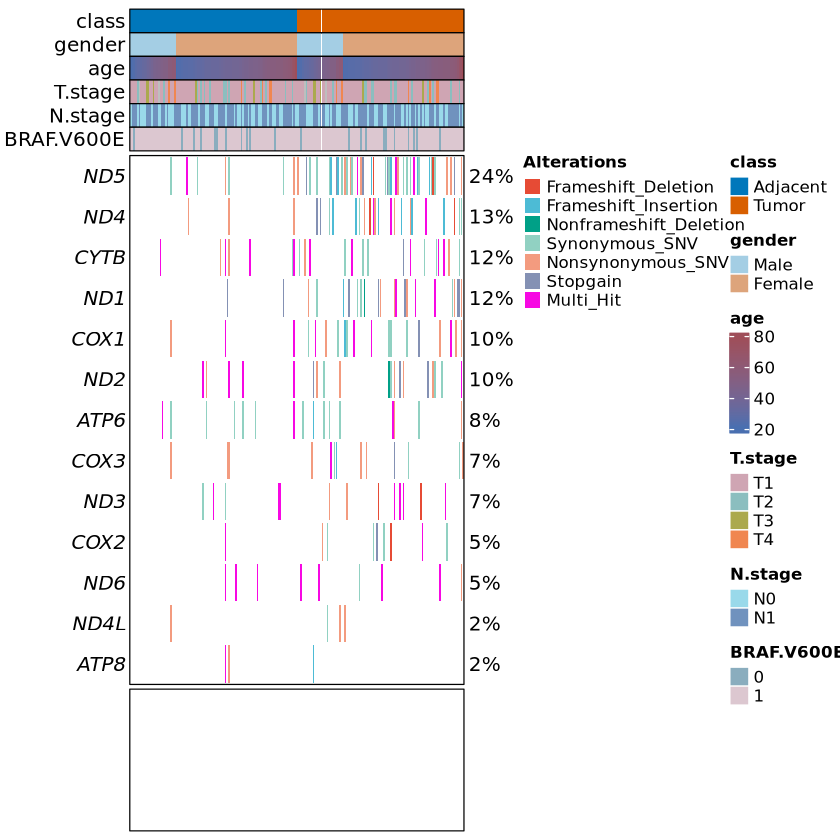

In [ ]:
p <- oncoPrint(SNV_ordered,
alter_fun = alter_fun,
col = vc_cols,
na_col = "white",
show_row_names = T,
show_column_names = F,
border = TRUE,
column_order= colnames(SNV_ordered),
remove_empty_rows = T, 
remove_empty_columns = F,
top_annotation = top_annotation,
bottom_annotation = HeatmapAnnotation(ggplot = anno_empty(height = unit(3, "cm"))),
right_annotation = NULL,
row_names_side = "left",
row_names_gp = gpar(fontface = "italic",fontsize = 12), 
column_names_gp = gpar(fontsize = 6), 
pct_gp = gpar(fontsize = 12),
pct_side = "right", 
show_heatmap_legend = T)
print(p)



In [249]:
sample_order <- data.frame(sample_order = clin$Sample)

In [ ]:

genes_in_snv <- rownames(SNV_ordered)
samples_in_snv <- colnames(SNV_ordered)

base_data <- mutation_exon %>%
  select(Sample, class, Gene.MT_ensGene,Mutation.Class,ExonicFunc.MT_ensGene)

filtered_data <- base_data %>%
  mutate(Gene.MT_ensGene = ifelse(Gene.MT_ensGene %in% genes_in_snv, Gene.MT_ensGene, NA)) %>%
  mutate(
    class = ifelse(!is.na(Gene.MT_ensGene), class, NA),
    ExonicFunc.MT_ensGene = ifelse(!is.na(Gene.MT_ensGene), ExonicFunc.MT_ensGene, NA)
  )

all_samples <- data.frame(Sample = samples_in_snv, stringsAsFactors = FALSE)

merged_data <- all_samples %>%
  left_join(filtered_data, by = "Sample")

filtered_data <- unique(merged_data %>%
  group_by(Sample) %>%
  mutate(has_annotation = any(!is.na(Gene.MT_ensGene) | !is.na(ExonicFunc.MT_ensGene))) %>%
  filter(
    (has_annotation & (!is.na(Gene.MT_ensGene) | !is.na(ExonicFunc.MT_ensGene))) |
    (!has_annotation & row_number() == 1)
  ) %>%
  ungroup() %>%
  mutate(
    class = ifelse(is.na(class), "", class),
    Gene.MT_ensGene = ifelse(is.na(Gene.MT_ensGene), "", Gene.MT_ensGene),
    ExonicFunc.MT_ensGene = ifelse(is.na(ExonicFunc.MT_ensGene), "", ExonicFunc.MT_ensGene)
  ) %>%
  arrange(factor(Sample, levels = samples_in_snv)))

filtered_data_new=filtered_data[,-6]

In [ ]:
library(dplyr)
library(tidyr)

filtered_data_new <- filtered_data_new %>%
  mutate(ExonicFunc.MT_ensGene = ifelse(is.na(ExonicFunc.MT_ensGene), "", ExonicFunc.MT_ensGene))

mutation_summary <- filtered_data_new %>%
  group_by(Sample) %>%
  summarise(has_annotation = any(ExonicFunc.MT_ensGene != ""), .groups = "drop") %>%
  left_join(
    filtered_data_new %>%
      filter(ExonicFunc.MT_ensGene != "") %>%
      group_by(Sample, Mutation.Class) %>%
      summarise(count = n(), .groups = "drop") %>%
      group_by(Sample) %>%
      mutate(percentage = round(100 * count / sum(count), 2)) %>%
      ungroup(),
    by = "Sample"
  ) %>%
  mutate(
    Mutation.Class = ifelse(has_annotation, Mutation.Class, NA),
    count = ifelse(has_annotation, count, NA),
    percentage = ifelse(has_annotation, percentage, NA)
  )

sample_order <- unique(filtered_data_new$Sample)
final_result <- mutation_summary %>%
  mutate(Sample = factor(Sample, levels = sample_order)) %>%
  arrange(Sample)


# A tibble: 6 × 5
  Sample        has_annotation Mutation.Class count percentage
  <fct>         <lgl>          <chr>          <int>      <dbl>
1 WES-K100571   FALSE          NA                NA         NA
2 KY-WES-137019 FALSE          NA                NA         NA
3 KY-131772     FALSE          NA                NA         NA
4 WES-K100616   FALSE          NA                NA         NA
5 KY-131732     FALSE          NA                NA         NA
6 KY-WES-136997 FALSE          NA                NA         NA
# A tibble: 6 × 5
  Sample        has_annotation Mutation.Class            count percentage
  <fct>         <lgl>          <chr>                     <int>      <dbl>
1 KY-WES-137007 TRUE           Substitution (Transition)     2       66.7
2 KY-131843     TRUE           Substitution (Transition)     1      100  
3 KY-WES-137023 TRUE           Substitution (Transition)     1      100  
4 KY-WES-136999 TRUE           Substitution (Transition)     4      100  
5 KY-WES-136973 

In [254]:
final_result <- final_result %>%
    mutate(Mutation.Class = recode(Mutation.Class, 
                                    `Substitution (Transition)` = "Transition", 
                                    `Substitution (Transversion)` = "Transversion"))

In [266]:
TT=final_result

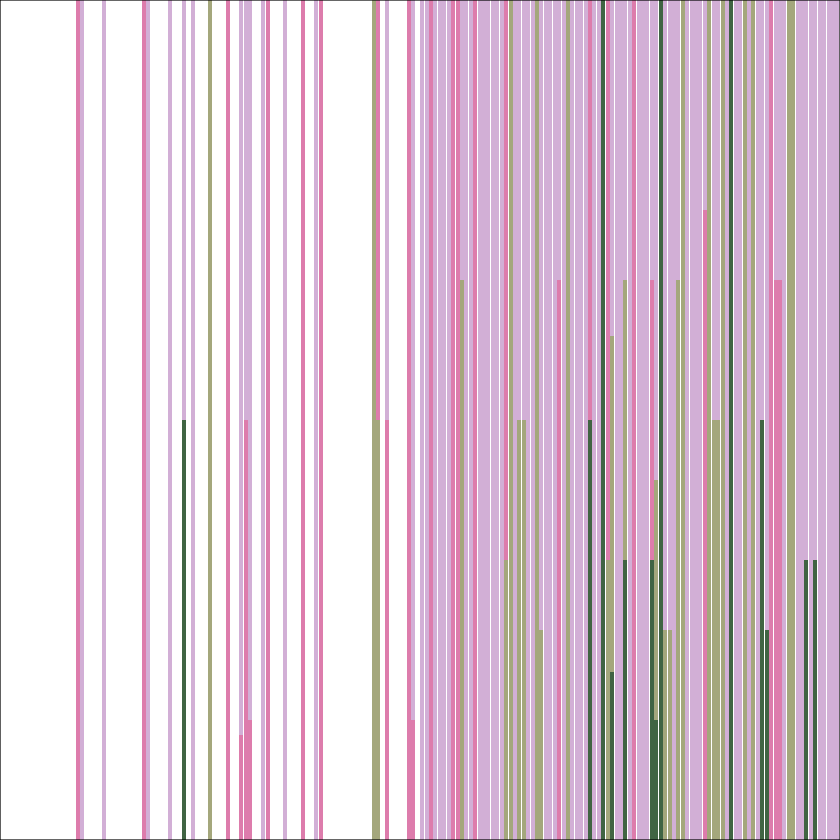

In [ ]:

TT$percentage[is.na(TT$Mutation.Class)] <- 100

TT$Mutation.Class <- factor(
  ifelse(is.na(TT$Mutation.Class), "NA", TT$Mutation.Class),
  levels = c("Transition", "Transversion", "Insertion", "Deletion", "NA")
)
TT$Sample <- factor(TT$Sample)

TT_p <- ggplot(data = TT, aes(x = Sample, y = percentage, fill = Mutation.Class)) +
  geom_bar(stat = "identity", position = "stack") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_fill_manual(
    name = "",
    values = c(
      "Transition" = "#D2AFD6",
      "Transversion" = "#DD7CAC",
      "Insertion" = "#A4A77C",
      "Deletion" = "#406443",
      "NA" = "white"
    )
  ) +
  theme_void() +
  theme(
    panel.border = element_rect(colour = "black", fill = "transparent"),
    legend.position = "none"
  )

print(TT_p)


In [ ]:
lgd <- Legend(at = c("Transition", 
                     "Transversion", 
                     "Insertion", 
                     "Deletion",
                     "NA"), 
              legend_gp = gpar(fill = c("#D2AFD6",  
                                         "#DD7CAC", 
                                         "#A4A77C", 
                                        "#406443",
                                        "white")), 
              title = "Substitution")

In [ ]:

pdf("plots/OncoPrint of 190 samples 530.pdf", width = 15, height = 7)

ht = draw(p)

column_order <- column_order(ht)
sample_order <- data.frame(sample_order = colnames(SNV)[column_order])

decorate_annotation("ggplot", { 
    vp = current.viewport()$name  
    print(vp = vp, TT_p)
})

draw(lgd, x = unit(0.85, "npc"), y = unit(0.1, "npc"))

dev.off()

pdf 
  2

In [ ]:
## 2

In [ ]:
library(maftools)
library(ComplexHeatmap)
library(dplyr)
library(tidyr)
library(tibble)

In [ ]:
tumor_mutation=read.table("95 tumor exon mutation maf.csv",sep=",",quote = "\"",header=T)
clinical_sample=read.table("190 samples exon gene mutation paired sample information1.csv",sep=",",quote = "\"",header=T)


In [ ]:
tumor_clinical=merge(tumor_mutation,clinical_sample[,-c(1,3)],by.x="Tumor_Sample_Barcode",by.y="Sample")

In [ ]:
tumor_clinical$Variant_Classification <- recode(tumor_clinical$Variant_Classification,
  "nonsynonymous SNV" = "Missense_Mutation",
  "synonymous SNV" = "Silent",
  "stopgain" = "Nonsense_Mutation",
  "frameshift deletion" = "Frame_Shift_Del",
  "frameshift insertion" = "Frame_Shift_Ins",
  "nonframeshift deletion" = "In_Frame_Del",
  "nonframeshift insertion" = "In_Frame_Ins"
)

In [ ]:
tumor_clinical$Variant_Type <- recode(tumor_clinical$Variant_Type,
  "Substitution (Transition)" = "SNP",
  "Substitution (Transversion)" = "SNP",
  "Insertion" = "INS",
  "Deletion" = "DEL"
)

In [ ]:
CLI.DF <- tumor_clinical %>%
  select('Tumor_Sample_Barcode', "gender","age","T.stage","N.stage","BRAF.V600E") %>%
  mutate(
    age = case_when(
      age < 55 ~ "<55",
      age >= 55  ~ ">=55")
  )

In [ ]:
laml <- read.maf(maf = tumor_clinical,clinicalData = CLI.DF,vc_nonSyn = NULL)

In [ ]:
plotmafSummary(maf = laml,
               rmOutlier = TRUE,
               addStat = 'median',
               dashboard = TRUE,
               titvRaw = FALSE)

In [ ]:
vc_cols <- c(
  "Missense_Mutation" ="#F39B7F",
  "Nonsense_Mutation" = "#8491B4",
  "Frame_Shift_Ins" = "#4DBBD5",
  "Frame_Shift_Del" = "#E64B35",
  "In_Frame_Ins" = "#3C5488",
  "In_Frame_Del" = "#00A087",
  "Silent_shown" = "#91D1C2",
  "Multi_Hit"="#F603E2F9"
)


In [ ]:
library(ComplexHeatmap)

annotationColor = list(
gender = c("Male" = "#A4CEE4", "Female" = "#DDA47B"),
age = c("<55" = "#496fb0", ">=55" = "#9F4E59"),
T.stage = c("T1" = "#cfa5b3", "T2" = "#8BBEBF", "T3" = "#aba94d", "T4" = "#F08650"),
N.stage = c("N0" = "#99D9EA", "N1" = "#7092BE"),
BRAF.V600E = c("0" = "#8AADBE", "1" = "#dcc7d0"))

In [ ]:
pdf("plots/oncoplot_top20_tumor_clinical.pdf", width = 13, height =9)
options(ComplexHeatmap.heatmap_annotation_na_col = "#f0f0f0")

oncoplot(
  maf = laml,
  clinicalFeatures = c("gender", "age", "T.stage", "N.stage", "BRAF.V600E"),
  top = 20,
  colors = vc_cols,
  removeNonMutated = FALSE,
  annotationColor = annotationColor,
  annotationFontSize = 1.3
)
dev.off()